# CIS6800: Project 6: SegFormer

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction

SegFormer is a simple architecture with some key innovations that allow it to acheive state of the art performance at much higher speeds and fewer parameters than other competing methods. In this assignment, you will be implementing the building blocks of SegFormer. An overview of the architecture is provided below. 

It is highly encouraged for you to review the SegFormer paper, available [here](https://arxiv.org/pdf/2105.15203.pdf). In particular, Section 3 contains detailed descriptions of the modules you will be implementing.

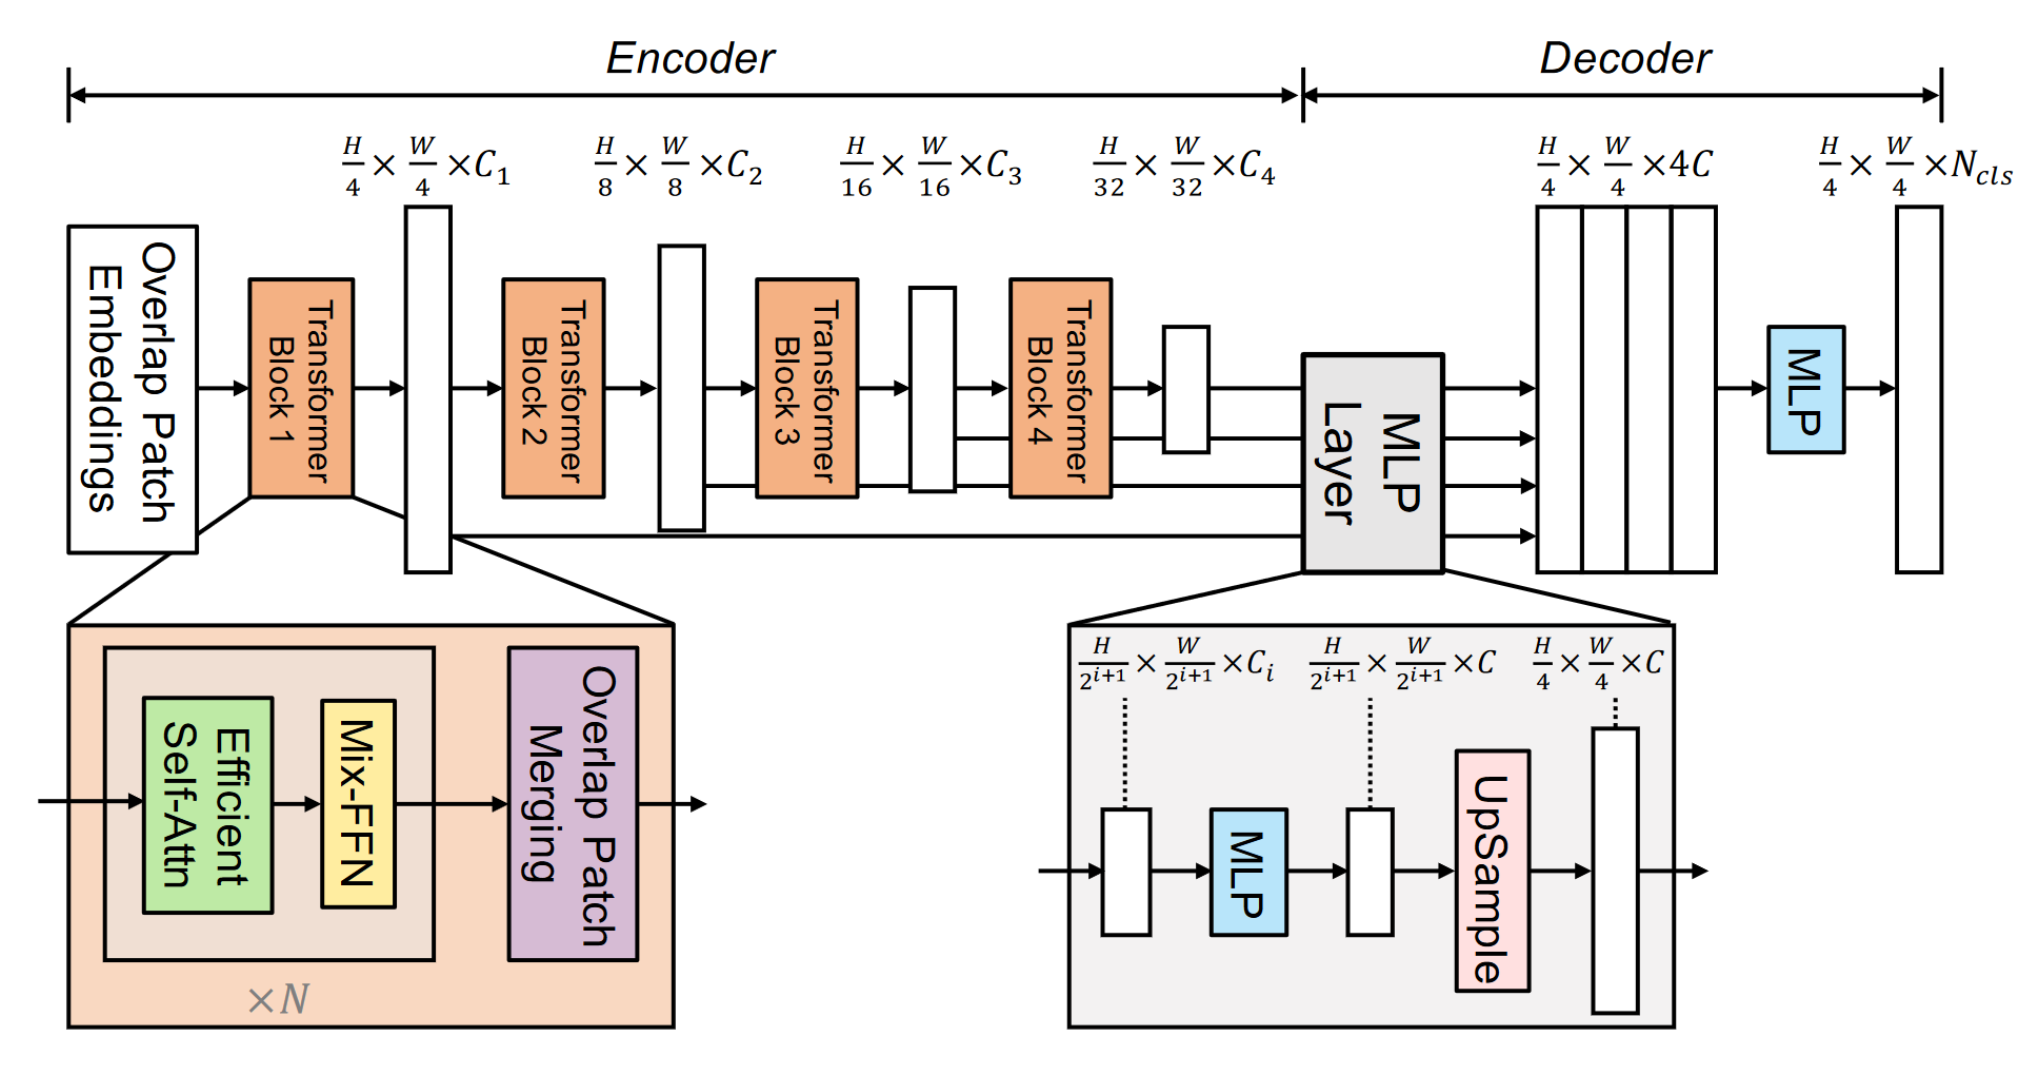 

In [ ]:
# !pip install pytorch-lightning torchbench

import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

## Data
For this assignment, we will use a simplified subset of ADE20K containg approximately 11,000 images with only four classes: "plant", "person/animal", "vehicle", and "background". The data in composed of a semantic class for each pixel - there is no distinction between different instances of the same object, unlike in previous assignments.

The following code downloads the original dataset, processes it, and visualizes an example.

In [ ]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1), 
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [ ]:
train_dataset = ADE20K('data', 'train', download=False, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

In [ ]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

In [ ]:
idx = 6005
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()
print(train_dataset[idx][1].shape)

## Modules
For this section, you will have to implement the base functionalities and modules for the SegFormer. As illustrated in the **Figure 2** and **Section 3** in the paper, we divide SegFormer into encoder-decoder sections. The encoder mainly consists of multiple layers of MixTransformerEncoderLayer, which then consists of OverlapPatchMergiing + (EfficientSelfAttention + MixFFN). While patch merging is relatively intuitive, you have to implement EfficientSelfAttention following **Equation 1** in the paper, and MixFFN as illustrated in **Equation 3**. On the other hand, the decoder section also consists of multiple decoder blocks, ending with a MLP. Refer to **Equation 4** for this part.

In [ ]:
# Combine adjacent patches to reduce feature map size, followed by LayerNorm
# Hint, patch merging can be accomplished with a single Conv2D module
class OverlapPatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding):
        super().__init__()
        #CNNs are used in overlap merging for the segformer. Because they can merge information across layers
        self.cn1 = nn.Conv2d(in_channels, out_channels, kernel_size=patch_size, stride = stride, padding = padding)
        self.layerNorm = nn.LayerNorm(out_channels)

    def forward(self, patches):
        """Merge patches to reduce dimensions of input.

        :param patches: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        #Patches = B, C, H, W
        #@TODO: Simulate and get the shapes
        x = self.cn1(patches)
        _,_,H, W = x.shape
        x = x.flatten(2).transpose(1,2) #Flatten - (B,C,H*W); transpose B,HW, C
        x = self.layerNorm(x)
        #Later in the stupid paper, they call HW = N
        #WE also denote C as embed dimension from now
        return x,H,W #B, N, EmbedDim

In [ ]:
# Perform attention with a reduced set of keys
# Hint, use a Linear layer followed by a LayerNorm before passing into MultiheadAttention
class EfficientSelfAttention(nn.Module):
    def __init__(self, channels, reduction_ratio, num_heads):
        super().__init__()
        assert channels % num_heads == 0, f"channels {channels} should be divided by num_heads {num_heads}."

        self.heads= num_heads

        #### Self Attention Block consists of 2 parts - Reduction and then normal Attention equation of queries and keys###
        
        # Reduction Parameters #
        self.cn1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=reduction_ratio, stride= reduction_ratio)
        self.ln1 = nn.LayerNorm(channels)
        # Attention Parameters #
        self.keyValueExtractor = nn.Linear(channels, channels * 2)
        self.query = nn.Linear(channels, channels)
        self.smax = nn.Softmax(dim=-1)
        self.finalLayer = nn.Linear(channels, channels) #Projection Layer


        
    #@NOTE - Added H and W to the input since we need to modify the shape
    def forward(self, x, H, W):

        """ Perform self attention with reduced sequence length

        :param x: tensor of shape (B, N, C) where
            B is the batch size,
            N is the number of queries (equal to H * W)
            C is the number of channels
        :return: tensor of shape (B, N, C)
        """
        B,N,C = x.shape
        # First lets do reduction
        # B, N, C -> B, C, N
        x1 = x.clone().permute(0,2,1)
        # BCN -> BCHW
        x1 = x1.reshape(B,C,H,W)
        # BCHW -> (Conv) -> BC, H/r,W/r
        x1 = self.cn1(x1)
        # BC, H/r, W/r -> B,C,HW/r -> B, HW/r, C
        x1 = x1.reshape(B,C,-1).permute(0,2,1)
        # Layer norm as in pyramid net
        x1 = self.ln1(x1)
        # We have got the Reduced Embeddings! We need to extract key and value pairs now
        # Linear transform to X -> XW+b (bnc -> bn2c)
        keyVal = self.keyValueExtractor(x1)
        # bn2c-> 2,b,heads, n, c/heads
        keyVal = keyVal.reshape(B, -1 , 2, self.heads, int(C/self.heads)).permute(2,0,3,1,4)
        #Extract Key and Value
        k,v = keyVal[0],keyVal[1] #b,heads, n, c/heads

        #Query -> b, heads, n, c/heads
        q = self.query(x).reshape(B, N, self.heads, int(C/self.heads)).permute(0, 2, 1, 3)

        #Finally we can do the attention thing
        dimHead = (C/self.heads)**0.5
        attention = self.smax(q@k.transpose(-2, -1)/dimHead)
        attention = (attention@v).transpose(1,2).reshape(B,N,C)

        x = self.finalLayer(attention) #B,N,C        
        return x

In [ ]:
# A feedforward network that mixes spatial information
# Should implement the following structure (inverse bottleneck):
#     mlp (channels -> expanded_channels)
#     depth-wise convolution (3 x 3)
#     activation function (gelu)
#     mlp (expanded_channels -> channels)
class MixFFN(nn.Module):
    def __init__(self, channels, expansion_factor):
        super().__init__()
        ### @WARNING: We are not doing skip connection inside this function, carry forward to the next fn, although given in the paper
        expanded_channels = channels*expansion_factor
        #Instead of the standard ViT MLP Layers, we use Convs to preserve spatial information for the Segformer architecture - wild
        #MLP Layer        
        self.mlp1 = nn.Linear(channels, expanded_channels)
        #Depth Wise CNN Layer
        self.depthwise = nn.Conv2d(expanded_channels, expanded_channels, kernel_size=3,  padding='same', groups=channels)
        #GELU
        self.gelu = nn.GELU()
        #MLP to predict
        self.mlp2 = nn.Linear(expanded_channels, channels)

    def forward(self, x, H, W):
        """ Perform self attention with reduced sequence length

        :param x: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        # Input BNC instead of BCHW
        # BNC -> B,N,C*exp 
        x = self.mlp1(x)
        B,N,C = x.shape
        # Prepare for the CNN operation, channel should be 1st dim
        # B,N, C*exp -> B, C*exp, H, W 
        x = x.transpose(1,2).view(B,C,H,W)

        #Depth Conv - B, N, Cexp 
        x = self.gelu(self.depthwise(x).flatten(2).transpose(1,2))

        #Back to the orignal shape
        x = self.mlp2(x) # BNC
        return x

In [ ]:
# Combine patch merging with n_layers of [attention followed by ffn]
class MixTransformerEncoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding, 
                 n_layers, reduction_ratio, num_heads, expansion_factor):
        super().__init__()
        self.patchMerge = OverlapPatchMerging(in_channels, out_channels, patch_size, stride, padding) # B N embed dim
        #You might be wondering why I didn't used a cleaner implementation but the input to each forward function is different
        self._attn = nn.ModuleList([EfficientSelfAttention(out_channels, reduction_ratio, num_heads) for _ in range(n_layers)])
        self._ffn = nn.ModuleList([MixFFN(out_channels,expansion_factor) for _ in range(n_layers)])
        self._lNorm = nn.ModuleList([nn.LayerNorm(out_channels) for _ in range(n_layers)])

    def forward(self, x):
        """ Run one block of the mix vision transformer

        :param x: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        #Extract orignal shape
        B,C,H,W = x.shape
        x,H,W = self.patchMerge(x) # B N embed dim (C)
        for i in range(len(self._attn)):
            x = x + self._attn[i].forward(x, H, W) #BNC
            x = x + self._ffn[i].forward(x, H, W) #BNC
            x = self._lNorm[i].forward(x) #BNC
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous() #BCHW
        return x

In [ ]:
# Merge multiple feature maps and produce predictions
# Should implement the following structure
#     mlp_i (in_channels -> embed_channels)
#     usample and concatenate
#     mlp (m * embed_channels -> embed_channels)
#     batch norm and relu
#     mlp (embed_channels -> num_classes)
from torch.nn.functional import interpolate
class MLPDecoder(nn.Module):
    def __init__(self, in_channels, embed_channels, out_dims, num_classes):
        """Initialize MLP Decoder.
        :param in_channels: list of int, number of input channels for each layeer
        :param embed_channels: int, common embedding channels
        :param out_dims: tuple, dimensions of common feature map
        """
        super().__init__()
        m = len(in_channels) #Assuming this is what is meant by m
        self.outDim = out_dims #Not sure where to use this
        #MLPi to get all features to common dim - I will use convs because linear seems funny on a 3D tensor
        self.mlp1 = nn.ModuleList([nn.Conv2d(in_channels[i],embed_channels, kernel_size=1) for i in range(m)])        
        self.mlp2 = nn.Conv2d(m*embed_channels, embed_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(embed_channels)
        self.relu = nn.ReLU(inplace=True)
        self.mlp3 = nn.Conv2d(embed_channels, num_classes, kernel_size=1)


    def forward(self, x):
        """ Take feature map to common shape
        :param x: list of tensors with shape (B, Ci, Hi, Wi)
            B is the Batch size
            Ci is the number of input Channels
            Hi and Wi are the input Height and Width
        :return: tensor with shape (B, C, H, W)
            B is the Batch size
            C is the number of output Channels
            H and W are the input Height and Width
        """
        # First Pass it through the MLP_i
        for i in range(len(x)):
            x[i] = self.mlp1[i].forward(x[i])
            x[i] = interpolate(x[i], size=self.outDim, mode='bilinear')
        #Concatenate
        x = torch.cat(x, dim = 1)
        x = self.relu(self.bn(self.mlp2(x)))
        x = self.mlp3(x) 


        
        return x

## Model and Training
We have provided you with a near-complete network template which you can indicate how a complete SegFormer is structured and how it calls the modules we have built. For validation step, you need to implement mean IoU as paper suggests.

In [198]:
# This is implemented for you! Just implement the miou
class SegFormer_B0(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder_blocks = nn.ModuleList([
            MixTransformerEncoderLayer(3, 32, patch_size=7, stride=4, padding=3, n_layers=2, reduction_ratio=8, num_heads=1, expansion_factor=8),
            MixTransformerEncoderLayer(32, 64, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=4, num_heads=2, expansion_factor=8),
            MixTransformerEncoderLayer(64, 160, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=2, num_heads=5, expansion_factor=4),
            MixTransformerEncoderLayer(160, 256, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=1, num_heads=8, expansion_factor=4)
        ])
        self.decoder = MLPDecoder([32, 64, 160, 256], 256, (64, 64), 4)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, images):
        embeds = [images]
        for block in self.encoder_blocks:
            embeds.append(block(embeds[-1]))
        return self.decoder(embeds[1:])
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=6e-5)
        return optimizer
    
    def miou(self, prediction, targets):
        # pred - B C H W , target B H W (C encoded inside the class itself) 

        thr = 1e-5

        C = prediction.size()[1]
        #Convert the prediction to same format as target (B H W)
        pred = prediction.argmax(dim = 1) #Across the channels get the highest prob

        validClass = C

        iou = 0

        for i in range(C):
            #Bools of the masks
            maskTar = targets == i
            maskPred = pred == i
            
            if(maskTar.sum()==0):
                validClass -= 1
                continue

            intersect = torch.logical_and(maskPred,maskTar).sum().item()
            union = torch.logical_or(maskPred, maskTar).sum().item()
            iou += intersect/(union+thr) #Stable in the sense of Lyapunov

        #Mean iou with valid classes
        iou = iou/validClass

        return iou

    def training_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.forward(images)
        loss = self.loss(predictions, targets)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.forward(images)
        miou = self.miou(predictions, targets)
        self.log('miou', miou, prog_bar=True)

In [ ]:
model = SegFormer_B0()
model = model.load_from_checkpoint(r'lightning_logs\version_17\checkpoints\epoch=0-step=346.ckpt')
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=40)
trainer.fit(model, train_loader,val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


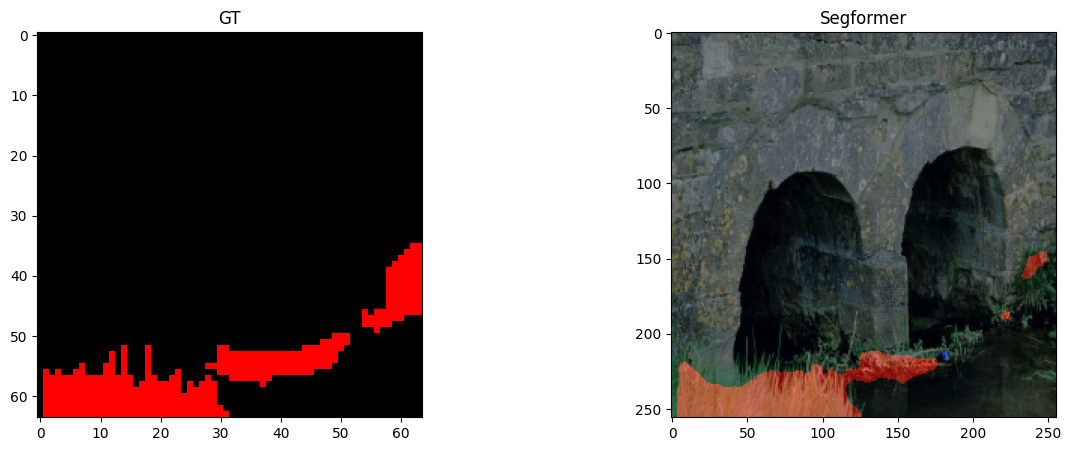

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


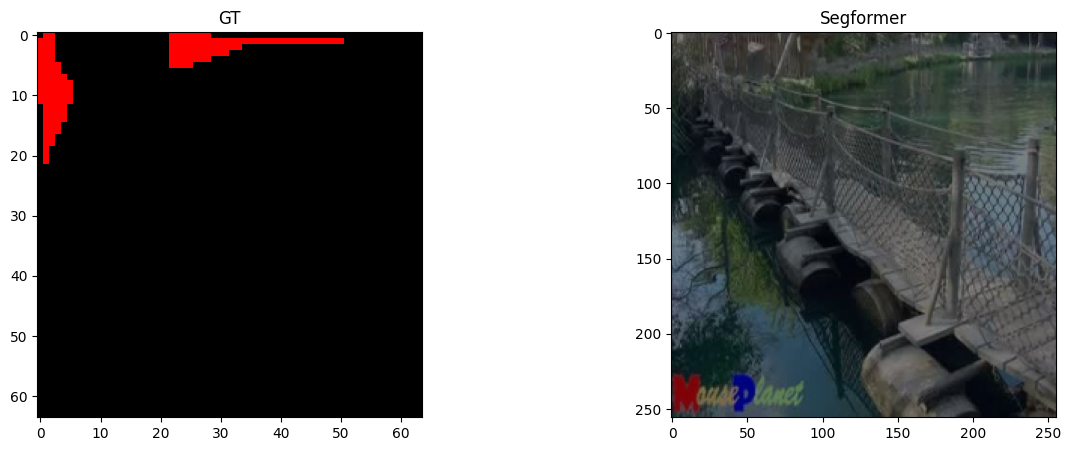

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


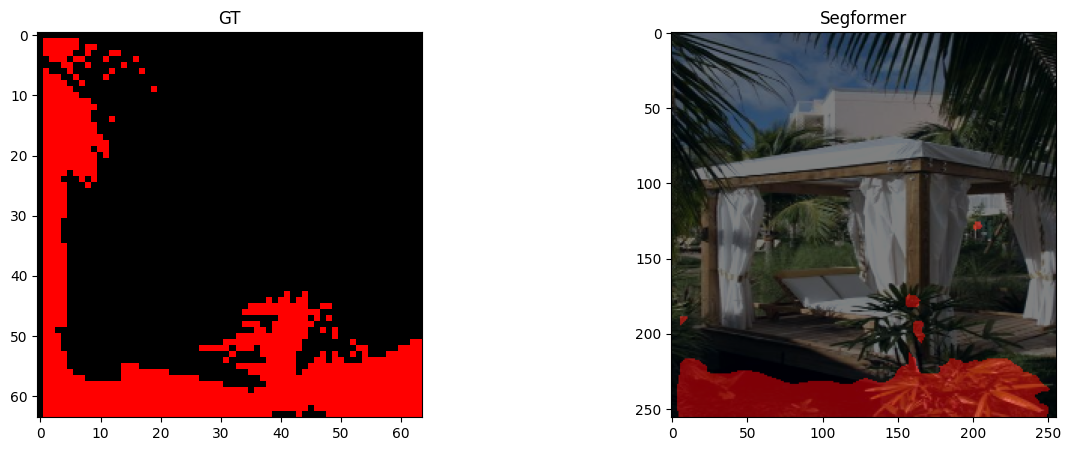

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


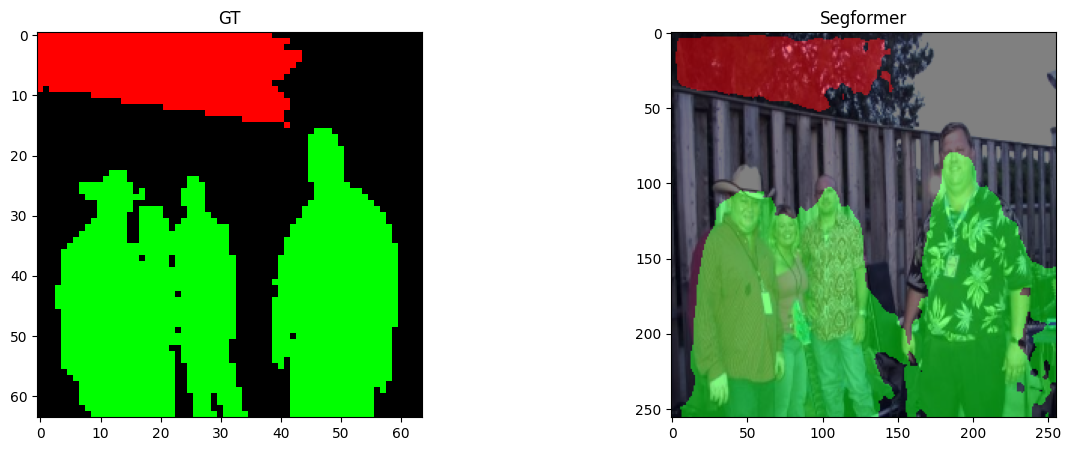

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


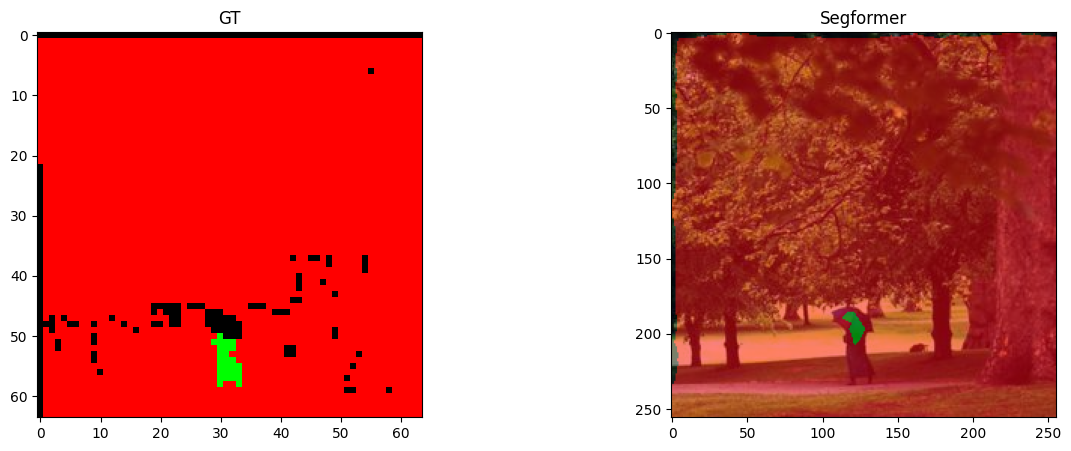

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


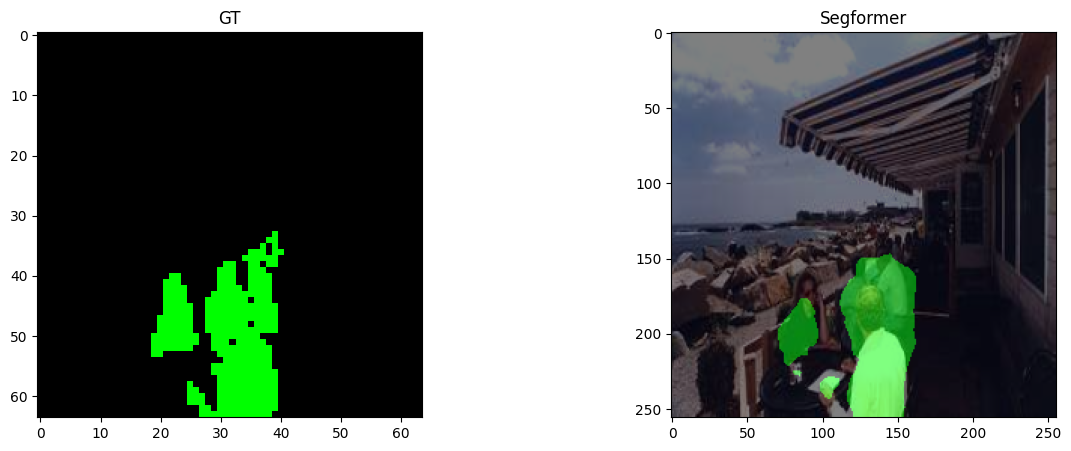

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


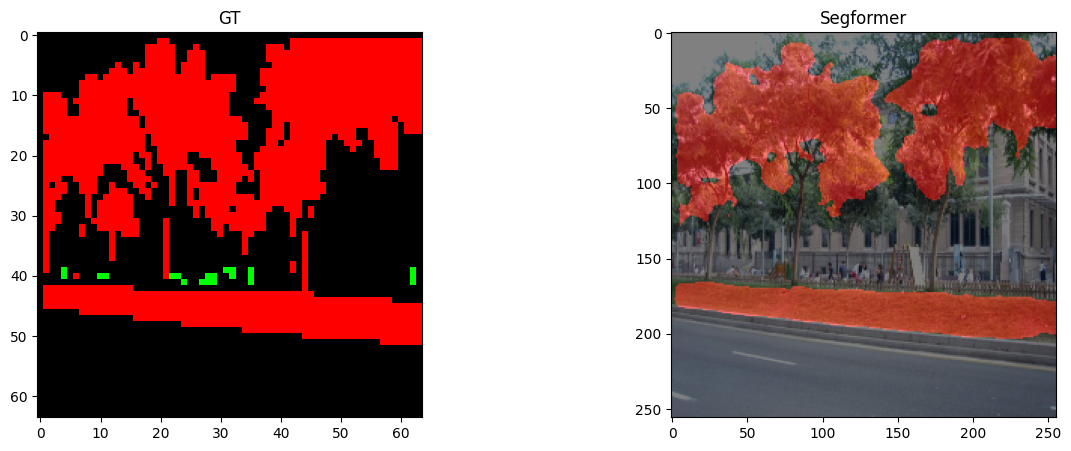

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


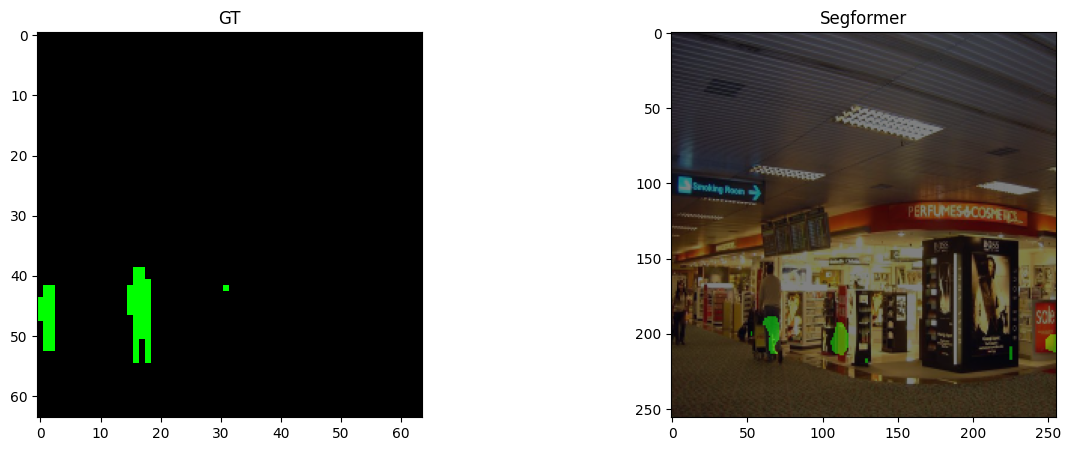

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


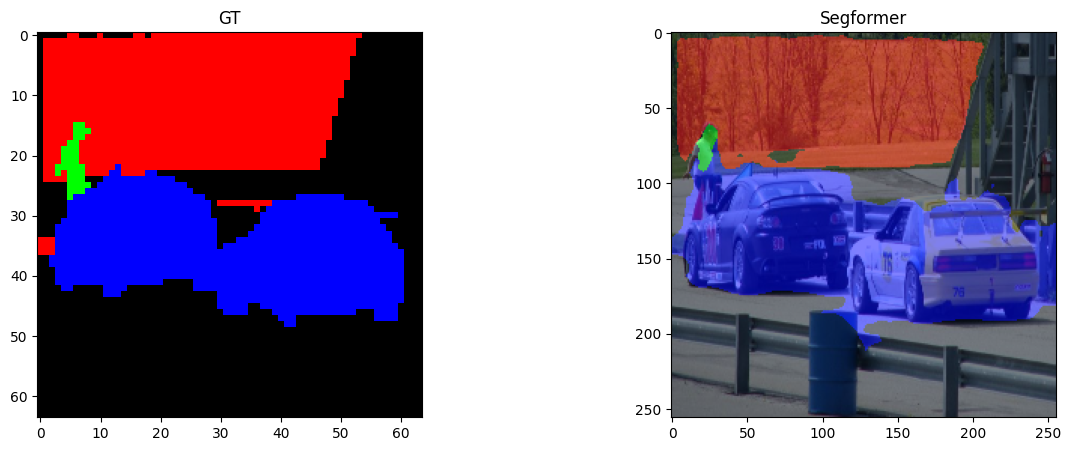

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


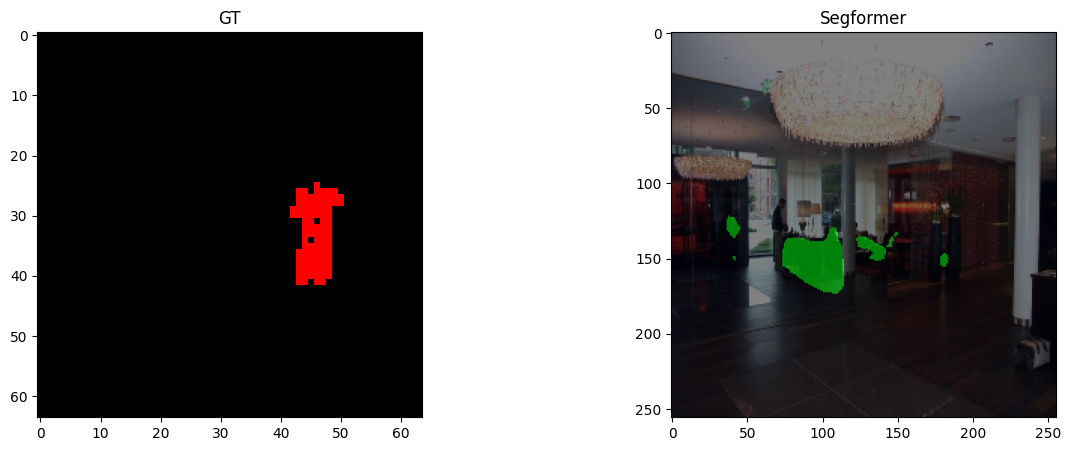

In [201]:
def visualizationPipeline(dataset, idx, model):
    #First Get the image and the label
    model.eval()
    with torch.no_grad():
        pred = model(dataset[idx][0].unsqueeze(0)) #batch is one
        pred = interpolate(pred, size = (256,256), mode = 'bilinear')
        pred = torch.argmax(pred, dim=1).squeeze(0).detach().numpy()  #Argmax to get the classes
    #TA's code to unnormalize the images
    img, label = (dataset[idx][0].permute(1, 2, 0) / 4 + 0.5).numpy(), (dataset[idx][1]).numpy()
    # Color Mask
    colors = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0],[0, 0, 255],[255, 255, 0]])  
    label = colors[label]
    pred = colors[pred]


    #Plotting - no one cares
    _, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(label, cmap='jet', interpolation='nearest')
    axs[0].set_title('GT')
    axs[1].imshow(img)
    axs[1].imshow(pred, alpha=0.5) 
    axs[1].set_title('Segformer')
    plt.show()

for i in range(10):
    idx = np.random.randint(0,10000)
    model.cpu()
    visualizationPipeline(train_dataset, idx, model)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn.functional import interpolate

idx = 1000
img, label = train_dataset[idx]
img2 = img.permute(1, 2, 0) / 4 + 0.5  # Normalize image to [0, 1]

# Get model prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(img.unsqueeze(0))  # Add batch dimension and get model output
    prediction = interpolate(output, size=(256, 256), mode='bilinear')
    prediction = torch.softmax(prediction, dim = 1)
    prediction = torch.argmax(prediction, dim=1).squeeze(0)  # Get the class with the highest probability for each pixel

# Convert to numpy for visualization
img = img2.numpy()
label = label.numpy()
prediction = prediction.numpy()

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Show image
axs[0].imshow(img)
axs[0].set_title('Input Image')
axs[0].axis('off')

# Show ground truth mask overlaid on image
# axs[1].imshow(img)
axs[1].imshow(label_color, alpha=0.5)  # Overlay mask
axs[1].set_title('Ground Truth Mask')
axs[1].axis('off')

# Show predicted mask overlaid on image
axs[2].imshow(img)
axs[2].imshow(prediction_color, alpha=0.5)  # Overlay mask
axs[2].set_title('Predicted Mask')
axs[2].axis('off')

plt.show()


## Results
Show your training curves and results on several images from the validation set. Provide a qualitative description of the performance of your model. Don't forget to upsample your predicted segmentation mask to the same resolution as the image! Segformer indeed has achieved great performance, there is a short demo on Cityspaces-C corrupted dataset on [YouTube](https://www.youtube.com/watch?v=J0MoRQzZe8U').

## Discussion Question
1. Why do we overlap and merge patches when reducing dimensions instead of e.g. max pool?
2. How does efficient self-attention affect the performance of the model?
3. Why do we only have one activation function in MixFFN?
4. If we removed padding='same' in MixFFN, would the performance of our model be affected? Why or why not? Suppose that there are no dimensional issues caused by this.
5. What is the difference between cross-entropy loss and miou? Why do we not use the miou to train?
6. Why are transformers especially suitable for this architecture? Namely, passing through different feature map stages and using a very small decoder. What problems might arise if we used convolutions instead?
7. Do you think that adding an FPN makes sense for this architecture? Justify your answer.
8. Your achieved performance is likely not very high, considering the simplicity of the data set. This assignment makes several simplications to the training process that contribute to this. Choose two such simplifications and explain why they degrade the achieved performance.